# Import Modules

In [171]:
import os
import pandas as pd
import numpy.random as rnd
import warnings
import json
import sqlalchemy as sql
import datetime
import yfinance as yf
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')



%matplotlib inline

#warnings.filterwarnings("ignore")
#pd.options.display.float_format = '{:.4%}'.format

# Data Input for Universe (Multiple Asset Classes)

In [172]:
# Date range
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365*5) #trading days(252) * amount of years to go back 

start = start_date.strftime("%Y-%m-%d")
end = today.strftime("%Y-%m-%d")

# Tickers of assets
assets = ["MSFT", "TSLA", "META", "UNH", "JNJ", "JPM", "V", "LLY", "AVGO", "PG", "MA", "HD", "MRK", "NVDA", "AMZN", "BRK-B",
         "GOOG", "XOM", "CVX", "PEP", "COST", "KO", "ABBV", "ADBE", "WMT", "MCD", "CSCO", "CRM"]
assets.sort()

# Downloading data
og_data = yf.download(assets, start = start, end = end)
data = og_data.loc[:,('Adj Close', slice(None))]
data.columns = assets

Y = data[assets].pct_change().dropna()

display(start)
display(end)
display(Y)

[*********************100%***********************]  28 of 28 completed


'2018-07-07'

'2023-07-06'

,ABBV,ADBE,AMZN,AVGO,BRK-B,COST,CRM,CSCO,CVX,GOOG,...,MRK,MSFT,NVDA,PEP,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-10,0.018549,-0.004564,0.002329,0.012650,0.001371,0.003603,0.004867,0.004453,0.012700,-0.001049,...,0.004515,0.002651,0.016048,0.047606,0.025173,0.012433,0.007372,0.008633,0.014896,0.009168
2018-07-11,-0.039255,-0.002051,0.006844,-0.028417,0.000053,-0.003543,0.019656,-0.006766,-0.031899,0.000919,...,-0.006420,-0.001371,-0.022586,-0.003100,-0.008268,-0.010885,-0.003718,0.010681,-0.007797,-0.012790
2018-07-12,0.017128,0.027205,0.023715,-0.137446,0.000263,0.014553,0.020034,0.023725,0.005991,0.025635,...,0.012278,0.021671,0.014948,-0.008975,-0.003411,-0.007054,0.005735,0.012667,-0.000115,0.001211
2018-07-13,0.010668,0.014596,0.009134,-0.035813,0.005264,0.011774,-0.003712,-0.041303,-0.001770,0.004512,...,0.003671,0.011901,-0.007603,0.010401,0.005324,0.006820,0.010350,-0.003431,0.013638,0.007498
2018-07-16,-0.003932,-0.015120,0.005218,0.003902,0.005446,-0.007804,-0.004403,0.017233,-0.008546,-0.004172,...,-0.004770,-0.004932,-0.004492,0.002396,0.002774,-0.027503,-0.006649,-0.006885,-0.000684,-0.009843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-28,-0.000679,-0.013980,-0.001084,-0.000542,-0.003549,0.004657,0.016042,0.000197,0.009054,0.017393,...,-0.007766,0.003826,-0.018125,-0.013532,-0.000200,0.024100,-0.016806,0.002727,0.005437,0.008130
2023-06-29,0.005434,0.002778,-0.008834,0.017254,0.008260,-0.002083,-0.008201,0.006684,0.008521,-0.008837,...,0.009783,-0.002382,-0.007175,0.000980,-0.004067,0.004917,0.004194,0.027900,-0.006760,0.012334
2023-06-30,0.011259,0.010790,0.019234,0.005634,0.012140,0.012583,0.003944,0.010350,0.007104,0.007999,...,0.016294,0.016386,0.036255,0.007287,0.015799,0.016582,0.008815,0.013486,0.018797,0.005155


In [173]:
#Y_cumulative_ret = (1 + Y).cumprod()
#Y_cumulative_ret

In [174]:
#Set the time period and trading days
time_period = 1
trading_days = 252 * time_period

In [175]:
thirty_day_stdev = pd.DataFrame((Y.std()*np.sqrt(30)), index = assets,
                                columns =['thirtyday_stdev'])
#thirty_day_stdev['thirty_day_stdev'] = thirty_day_stdev[start, start+30]
                                
#thirty_day_stdev = thirty_day_stdev
thirty_day_stdev.head()

,thirtyday_stdev
ABBV,0.091702
ADBE,0.131575
AMZN,0.125765
AVGO,0.129525
BRK-B,0.078080


In [176]:
annual_stdev= pd.DataFrame((Y.std()*np.sqrt(trading_days)), index = assets,
                                columns =['annual_stdev'])
annual_stdev.head()

,annual_stdev
ABBV,0.265777
ADBE,0.381341
AMZN,0.364501
AVGO,0.375400
BRK-B,0.226296


In [177]:
annualized_avg_return_calc = Y.mean() * trading_days
annualized_average_returns = pd.DataFrame(annualized_avg_return_calc, columns = ['Annual Average Returns'], index=assets)
annualized_average_returns.head()

,Annual Average Returns
ABBV,0.152850
ADBE,0.207297
AMZN,0.147737
AVGO,0.356730
BRK-B,0.143773


In [178]:
# Calculate the annualized Sharpe Ratios
sharpe_ratios_calc = annualized_average_returns['Annual Average Returns'] / annual_stdev['annual_stdev']
sharpe_ratios = pd.DataFrame(sharpe_ratios_calc, columns = ['sharpe_ratio'], index=assets)
sharpe_ratios.head()

,sharpe_ratio
ABBV,0.575105
ADBE,0.543601
AMZN,0.405311
AVGO,0.950266
BRK-B,0.635330


## Create Dataframe with different measures of volatility

In [179]:
# Merge all of the dataframes
asset_quant_data = pd.concat([annual_stdev, thirty_day_stdev,sharpe_ratios], axis =1)
                    
#display(asset_quant_data.head())
#display(asset_quant_data.tail())
asset_quant_data.head()

,annual_stdev,thirtyday_stdev,sharpe_ratio
ABBV,0.265777,0.091702,0.575105
ADBE,0.381341,0.131575,0.543601
AMZN,0.364501,0.125765,0.405311
AVGO,0.375400,0.129525,0.950266
BRK-B,0.226296,0.078080,0.635330


## k-means modeling to cluster assets

In [180]:
scaled_data = StandardScaler()

asset_data_scaled = scaled_data.fit_transform(asset_quant_data[['annual_stdev','thirtyday_stdev','sharpe_ratio']])



In [181]:
# Create a DataFrame with the scaled data
asset_data_scaled = pd.DataFrame(
    asset_data_scaled,
    columns=asset_quant_data.columns
)

# Copy the asset names from the original data
asset_data_scaled["Asset_Name"] = asset_quant_data.index

# Set the asset_name column as index
asset_data_scaled = asset_data_scaled.set_index("Asset_Name")

# Display sample data
asset_data_scaled.head()

,annual_stdev,thirtyday_stdev,sharpe_ratio
Asset_Name,,,
ABBV,-0.512326,-0.512326,-0.409845
ADBE,0.622970,0.622970,-0.541839
AMZN,0.457536,0.457536,-1.121222
AVGO,0.564599,0.564599,1.161947
BRK-B,-0.900184,-0.900184,-0.157524


In [182]:
# Create a list with the number of k-values to try
# Use a range from 1 to 10
k = list(range(1,10))

In [183]:
# Create an empy list to store the inertia values
inertia = []

In [184]:
for i in k:
    k_model = KMeans(n_clusters = i, random_state = 1)
    k_model.fit(asset_data_scaled)
    inertia.append(k_model.inertia_)

In [185]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k":k, "inertia":inertia}

# Create a DataFrame with the data to plot the Elbow curve
elbow_df = pd.DataFrame(elbow_data)

#check dataframe
elbow_df.head()

,k,inertia
0,1,84.000000
1,2,45.249932
2,3,24.970037
3,4,14.936384
4,5,10.378315


In [186]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_df.hvplot.line(x = "k", y = "inertia", title = "Elbow Curve", xticks = k)

:Curve   [k]   (inertia)

In [187]:
# Initialize the K-Means model using the best value for k
model = KMeans (n_clusters = 4, random_state = 1)

In [188]:
# Fit the K-Means model using the scaled data
model.fit(asset_data_scaled)

KMeans(n_clusters=4, random_state=1)

In [189]:
# Predict the clusters to group the assets using the scaled data
k = model.predict(asset_data_scaled)

# View the resulting array of cluster values.
k

array([3, 0, 0, 2, 3, 3, 0, 0, 0, 0, 0, 3, 0, 3, 2, 0, 3, 0, 3, 2, 1, 3,
       3, 1, 0, 0, 3, 0], dtype=int32)

In [190]:
# Create a copy of the DataFrame
asset_data_scaled_predict = asset_data_scaled.copy()

In [191]:
# Add a new column to the DataFrame with the predicted clusters
asset_data_scaled_predict["clusters"] = k

# Display sample data
asset_data_scaled_predict.head()

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters
Asset_Name,,,,
ABBV,-0.512326,-0.512326,-0.409845,3
ADBE,0.622970,0.622970,-0.541839,0
AMZN,0.457536,0.457536,-1.121222,0
AVGO,0.564599,0.564599,1.161947,2
BRK-B,-0.900184,-0.900184,-0.157524,3


In [192]:
cluster_characteristics = asset_data_scaled_predict.groupby("clusters").mean()[["sharpe_ratio", "annual_stdev"]]

In [193]:
def label_clusters(row):
    if row['annual_stdev'] > cluster_characteristics['annual_stdev'].median() and row['sharpe_ratio'] > cluster_characteristics['sharpe_ratio'].median():
        return 'HighRisk-HighReturn'
    elif row['annual_stdev'] < cluster_characteristics['annual_stdev'].median() and row['sharpe_ratio'] < cluster_characteristics['sharpe_ratio'].median():
        return 'LowRisk-LowReturn'
    else:
        return 'MediumRisk-MediumReturn'

In [194]:
cluster_characteristics['cluster_label'] = cluster_characteristics.apply(label_clusters, axis=1)

In [195]:
asset_data_scaled_predict['cluster_label'] = asset_data_scaled_predict['clusters'].map(cluster_characteristics['cluster_label'])

In [196]:
print(asset_data_scaled_predict)

            annual_stdev  thirtyday_stdev  sharpe_ratio  clusters  \
Asset_Name                                                          
ABBV           -0.512326        -0.512326     -0.409845         3   
ADBE            0.622970         0.622970     -0.541839         0   
AMZN            0.457536         0.457536     -1.121222         0   
AVGO            0.564599         0.564599      1.161947         2   
BRK-B          -0.900184        -0.900184     -0.157524         3   
COST           -0.722413        -0.722413      1.168424         3   
CRM             0.778078         0.778078     -1.124049         0   
CSCO           -0.291718        -0.291718     -1.221055         0   
CVX             0.379426         0.379426     -1.040023         0   
GOOG            0.016215         0.016215     -0.165245         0   
HD             -0.285269        -0.285269     -0.510809         0   
JNJ            -1.119005        -1.119005     -0.786748         3   
JPM             0.045182         0

## Charts and summary of k-means

In [197]:
# Create a scatter plot using hvPlot by setting 
# `x="Sharpe Ratio"` and `y="Annual Average Returns"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the assets represented by each data point.
asset_data_scaled_predict.hvplot.scatter(
    x="annual_stdev", 
    y="sharpe_ratio",
    by = "clusters",
    hover_cols = "all").opts(yformatter="%.0f")


:NdOverlay   [clusters]
   :Scatter   [annual_stdev]   (sharpe_ratio,Asset_Name,thirtyday_stdev,clusters,cluster_label)

In [198]:
portfolio_model = pd.concat([asset_data_scaled_predict,annualized_average_returns],axis =1)
portfolio_model.head()

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,cluster_label,Annual Average Returns
ABBV,-0.512326,-0.512326,-0.409845,3,LowRisk-LowReturn,0.152850
ADBE,0.622970,0.622970,-0.541839,0,MediumRisk-MediumReturn,0.207297
AMZN,0.457536,0.457536,-1.121222,0,MediumRisk-MediumReturn,0.147737
AVGO,0.564599,0.564599,1.161947,2,MediumRisk-MediumReturn,0.356730
BRK-B,-0.900184,-0.900184,-0.157524,3,LowRisk-LowReturn,0.143773


In [199]:
portfolio_model.hvplot.scatter(
    x="annual_stdev", 
    y="Annual Average Returns",
    by = "clusters",
    hover_cols = "all").opts(yformatter="%.0f")

:NdOverlay   [clusters]
   :Scatter   [annual_stdev]   (Annual Average Returns,index,thirtyday_stdev,sharpe_ratio,clusters,cluster_label)

In [200]:
#list the clusters
cluster1 = portfolio_model.where(portfolio_model["clusters"]==0).dropna()
cluster1

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,cluster_label,Annual Average Returns
ADBE,0.622970,0.622970,-0.541839,0.0,MediumRisk-MediumReturn,0.207297
AMZN,0.457536,0.457536,-1.121222,0.0,MediumRisk-MediumReturn,0.147737
CRM,0.778078,0.778078,-1.124049,0.0,MediumRisk-MediumReturn,0.160693
CSCO,-0.291718,-0.291718,-1.221055,0.0,MediumRisk-MediumReturn,0.109956
CVX,0.379426,0.379426,-1.040023,0.0,MediumRisk-MediumReturn,0.151424
GOOG,0.016215,0.016215,-0.165245,0.0,MediumRisk-MediumReturn,0.202449
HD,-0.285269,-0.285269,-0.510809,0.0,MediumRisk-MediumReturn,0.159180
JPM,0.045182,0.045182,-0.972083,0.0,MediumRisk-MediumReturn,0.142205
MA,0.115612,0.115612,-0.341894,0.0,MediumRisk-MediumReturn,0.194957
META,1.283714,1.283714,-1.178764,0.0,MediumRisk-MediumReturn,0.175661


In [201]:
cluster2 = portfolio_model.where(portfolio_model["clusters"]==1).dropna()
cluster2

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,cluster_label,Annual Average Returns
NVDA,2.148141,2.148141,1.322760,1.0,HighRisk-HighReturn,0.530502
TSLA,3.416532,3.416532,1.844772,1.0,HighRisk-HighReturn,0.741092


In [202]:
cluster3 = portfolio_model.where(portfolio_model["clusters"]==2).dropna()
cluster3

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,cluster_label,Annual Average Returns
AVGO,0.564599,0.564599,1.161947,2.0,MediumRisk-MediumReturn,0.356730
LLY,-0.162562,-0.162562,2.704046,2.0,MediumRisk-MediumReturn,0.397322
MSFT,-0.055429,-0.055429,1.219059,2.0,MediumRisk-MediumReturn,0.301011


In [203]:
cluster4 = portfolio_model.where(portfolio_model["clusters"]==3).dropna()
cluster4

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,cluster_label,Annual Average Returns
ABBV,-0.512326,-0.512326,-0.409845,3.0,LowRisk-LowReturn,0.152850
BRK-B,-0.900184,-0.900184,-0.157524,3.0,LowRisk-LowReturn,0.143773
COST,-0.722413,-0.722413,1.168424,3.0,LowRisk-LowReturn,0.232615
JNJ,-1.119005,-1.119005,-0.786748,3.0,LowRisk-LowReturn,0.098980
KO,-1.018569,-1.018569,-0.503227,3.0,LowRisk-LowReturn,0.118438
MCD,-0.824889,-0.824889,0.314455,3.0,LowRisk-LowReturn,0.174999
MRK,-0.850901,-0.850901,0.597353,3.0,LowRisk-LowReturn,0.188637
PEP,-0.966520,-0.966520,0.293756,3.0,LowRisk-LowReturn,0.163130
PG,-0.991318,-0.991318,0.745231,3.0,LowRisk-LowReturn,0.184641
WMT,-0.904990,-0.904990,0.249138,3.0,LowRisk-LowReturn,0.165379


In [204]:
Matching Client Risk Tolerance to Cluster

SyntaxError: invalid syntax (3870137052.py, line 1)

In [205]:
# Open and load the JSON file assumed to be named "x"
with open('x.json') as f:
    data = json.load(f)

# Retrieve aggregate score
aggregate_client_score = x['key']

FileNotFoundError: [Errno 2] No such file or directory: 'x.json'

In [220]:
# test score
aggregate_client_score = .54

In [221]:
def get_matching_clusters(aggregate_client_score, portfolio_model):
    if aggregate_client_score < 0.33:
        target_label = 'LowRisk-LowReturn'
    elif aggregate_client_score > 0.67:
        target_label = 'HighRisk-HighReturn'
    else:
        target_label = 'MediumRisk-MediumReturn'
    
    # Filter the dataframe for the target label
    matching_cluster = portfolio_model[portfolio_model['cluster_label'] == target_label]
    
    return matching_cluster

In [225]:
matching_cluster = get_matching_clusters(aggregate_client_score, portfolio_model)

matching_cluster

,annual_stdev,thirtyday_stdev,sharpe_ratio,clusters,cluster_label,Annual Average Returns
ADBE,0.622970,0.622970,-0.541839,0,MediumRisk-MediumReturn,0.207297
AMZN,0.457536,0.457536,-1.121222,0,MediumRisk-MediumReturn,0.147737
AVGO,0.564599,0.564599,1.161947,2,MediumRisk-MediumReturn,0.356730
CRM,0.778078,0.778078,-1.124049,0,MediumRisk-MediumReturn,0.160693
CSCO,-0.291718,-0.291718,-1.221055,0,MediumRisk-MediumReturn,0.109956
CVX,0.379426,0.379426,-1.040023,0,MediumRisk-MediumReturn,0.151424
GOOG,0.016215,0.016215,-0.165245,0,MediumRisk-MediumReturn,0.202449
HD,-0.285269,-0.285269,-0.510809,0,MediumRisk-MediumReturn,0.159180
JPM,0.045182,0.045182,-0.972083,0,MediumRisk-MediumReturn,0.142205
LLY,-0.162562,-0.162562,2.704046,2,MediumRisk-MediumReturn,0.397322


## Leveraging Machine Learning to Create trades of Equity within cluster

In [226]:
# Create a list of assets from a cluster.
cluster_list = []
cluster_list = matching_cluster.index

list(cluster_list)


['ADBE',
 'AMZN',
 'AVGO',
 'CRM',
 'CSCO',
 'CVX',
 'GOOG',
 'HD',
 'JPM',
 'LLY',
 'MA',
 'META',
 'MSFT',
 'UNH',
 'V',
 'XOM']

In [115]:
#Slice input dataframe Y with cluster with timestamp data as index
signals_df = pd.DataFrame(Y, columns = list(cluster_list)).reset_index()

#set data frame date colume to date time index
signals_df['Date']=pd.to_datetime(signals_df['Date'],
                                         infer_datetime_format=True,
                                 )

signals_df = signals_df.set_index('Date')

#show data frame 
signals_df

,NVDA,TSLA
Date,,
2018-07-10,0.016048,0.012433
2018-07-11,-0.022586,-0.010885
2018-07-12,0.014948,-0.007054
2018-07-13,-0.007603,0.006820
2018-07-16,-0.004492,-0.027503
...,...,...
2023-06-28,-0.018125,0.024100
2023-06-29,-0.007175,0.004917
2023-06-30,0.036255,0.016582


In [90]:
# Set the short window and long window
short_window = 10
long_window = 90

# Generate the fast and slow simple moving averages (10 and 90 days, respectively for one Asset)
signals_df['SMA_Fast'] = signals_df[cluster_list[0]].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df[cluster_list[0]].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow
Date,,,,,,,,,,,,,,,
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011602,0.000000,-0.022924,0.000442,-0.000234
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003208,0.007345,0.005028,-0.020622,-0.002977,0.014491,-0.015823,-0.001646,-0.007821,-0.004115,-0.000347
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018672,0.010337,-0.001909,-0.000101
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000727,-0.008321,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453
2018-11-19,-0.080372,-0.050910,-0.087061,-0.012945,0.003024,-0.039087,-0.019376,0.007637,-0.049035,-0.057192,-0.018664,-0.038664,0.003293,-0.008193,-0.001508


,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow
Date,,,,,,,,,,,,,,,
2023-06-28,-0.013980,-0.001084,0.016042,0.000197,0.009054,0.017393,-0.023044,-0.004382,-0.004086,-0.006131,-0.016806,0.002727,0.008130,0.000827,0.003375
2023-06-29,0.002778,-0.008834,-0.008201,0.006684,0.008521,-0.008837,0.004274,0.034923,0.019567,-0.013180,0.004194,0.027900,0.012334,0.000992,0.003658
2023-06-30,0.010790,0.019234,0.003944,0.010350,0.007104,0.007999,0.009161,0.014014,0.014523,0.019359,0.008815,0.013486,0.005155,-0.000302,0.004094
2023-07-03,-0.007730,-0.001074,0.001846,0.001546,-0.000890,-0.003389,-0.001996,0.008045,0.001678,-0.003345,-0.005742,0.002063,0.001958,-0.001945,0.003944
2023-07-05,0.004225,0.001229,0.010253,0.001555,-0.005725,0.017170,0.002516,-0.006662,0.001955,0.029194,-0.013937,0.006219,-0.005118,0.000360,0.004045


In [91]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df[cluster_list[0]] >= 0), 'Signal'] = 1

# When Actual Returns are less than -1, generate signal to sell the stock short
signals_df.loc[(signals_df[cluster_list[0]] < 0), 'Signal'] = 0

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal
Date,,,,,,,,,,,,,,,,
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011602,0.000000,-0.022924,0.000442,-0.000234,1.0
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003208,0.007345,0.005028,-0.020622,-0.002977,0.014491,-0.015823,-0.001646,-0.007821,-0.004115,-0.000347,0.0
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018672,0.010337,-0.001909,-0.000101,1.0
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000727,-0.008321,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453,0.0
2018-11-19,-0.080372,-0.050910,-0.087061,-0.012945,0.003024,-0.039087,-0.019376,0.007637,-0.049035,-0.057192,-0.018664,-0.038664,0.003293,-0.008193,-0.001508,0.0


,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal
Date,,,,,,,,,,,,,,,,
2023-06-28,-0.013980,-0.001084,0.016042,0.000197,0.009054,0.017393,-0.023044,-0.004382,-0.004086,-0.006131,-0.016806,0.002727,0.008130,0.000827,0.003375,0.0
2023-06-29,0.002778,-0.008834,-0.008201,0.006684,0.008521,-0.008837,0.004274,0.034923,0.019567,-0.013180,0.004194,0.027900,0.012334,0.000992,0.003658,1.0
2023-06-30,0.010790,0.019234,0.003944,0.010350,0.007104,0.007999,0.009161,0.014014,0.014523,0.019359,0.008815,0.013486,0.005155,-0.000302,0.004094,1.0
2023-07-03,-0.007730,-0.001074,0.001846,0.001546,-0.000890,-0.003389,-0.001996,0.008045,0.001678,-0.003345,-0.005742,0.002063,0.001958,-0.001945,0.003944,0.0
2023-07-05,0.004225,0.001229,0.010253,0.001555,-0.005725,0.017170,0.002516,-0.006662,0.001955,0.029194,-0.013937,0.006219,-0.005118,0.000360,0.004045,1.0


In [92]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df[cluster_list[0]] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,,,,,,,,,,,,
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011602,0.000000,-0.022924,0.000442,-0.000234,1.0,NaN
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003208,0.007345,0.005028,-0.020622,-0.002977,0.014491,-0.015823,-0.001646,-0.007821,-0.004115,-0.000347,0.0,-0.014744
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018672,0.010337,-0.001909,-0.000101,1.0,0.000000
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000727,-0.008321,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453,0.0,-0.004418
2018-11-19,-0.080372,-0.050910,-0.087061,-0.012945,0.003024,-0.039087,-0.019376,0.007637,-0.049035,-0.057192,-0.018664,-0.038664,0.003293,-0.008193,-0.001508,0.0,-0.000000


,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,,,,,,,,,,,,
2023-06-28,-0.013980,-0.001084,0.016042,0.000197,0.009054,0.017393,-0.023044,-0.004382,-0.004086,-0.006131,-0.016806,0.002727,0.008130,0.000827,0.003375,0.0,-0.01398
2023-06-29,0.002778,-0.008834,-0.008201,0.006684,0.008521,-0.008837,0.004274,0.034923,0.019567,-0.013180,0.004194,0.027900,0.012334,0.000992,0.003658,1.0,0.00000
2023-06-30,0.010790,0.019234,0.003944,0.010350,0.007104,0.007999,0.009161,0.014014,0.014523,0.019359,0.008815,0.013486,0.005155,-0.000302,0.004094,1.0,0.01079
2023-07-03,-0.007730,-0.001074,0.001846,0.001546,-0.000890,-0.003389,-0.001996,0.008045,0.001678,-0.003345,-0.005742,0.002063,0.001958,-0.001945,0.003944,0.0,-0.00773
2023-07-05,0.004225,0.001229,0.010253,0.001555,-0.005725,0.017170,0.002516,-0.006662,0.001955,0.029194,-0.013937,0.006219,-0.005118,0.000360,0.004045,1.0,0.00000


<AxesSubplot:xlabel='Date'>

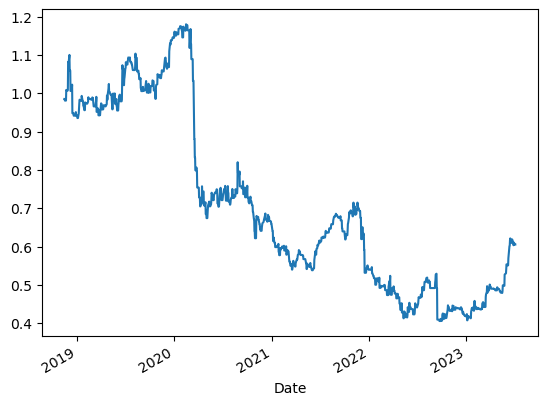

In [93]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [94]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
Date,,
2018-11-14,0.000442,-0.000234
2018-11-15,-0.004115,-0.000347
2018-11-16,-0.001909,-0.000101
2018-11-19,-0.000051,-0.000453
2018-11-20,-0.008193,-0.001508


In [95]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

1.0    630
0.0    536
Name: Signal, dtype: int64

In [96]:
# slice the dataframe to exclude any data before the first half of 2020
X = X['2020-07-01' : end]

In [97]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)
type(training_begin)

2020-07-01 00:00:00


pandas._libs.tslibs.timestamps.Timestamp

In [98]:
# Select the ending period for the training data with an offset of 6 months
training_end = X.index.min()+ DateOffset(months=6)

# Display the training end date
print(training_end)

2021-01-01 00:00:00


In [99]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-01,0.005736,0.002600
2020-07-02,0.006328,0.003178
2020-07-06,0.005356,0.003556
2020-07-07,0.005737,0.003685
2020-07-08,0.002540,0.004042


In [100]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-01,0.005736,0.002600
2020-07-02,0.006328,0.003178
2020-07-06,0.005356,0.003556
2020-07-07,0.005737,0.003685
2020-07-08,0.002540,0.004042


In [101]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [102]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled,y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Backtesting data for the trading model

In [103]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Generate classification report
report = svm_testing_report

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       304
         1.0       0.52      1.00      0.68       325

    accuracy                           0.52       629
   macro avg       0.26      0.50      0.34       629
weighted avg       0.27      0.52      0.35       629



In [104]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df[cluster_list[0]]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2021-01-04,1.0,-0.029553,-0.029553
2021-01-05,1.0,0.000721,0.000721
2021-01-06,1.0,-0.039902,-0.039902
2021-01-07,1.0,0.024512,0.024512
2021-01-08,1.0,0.015406,0.015406


,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-06-28,1.0,-0.013980,-0.013980
2023-06-29,1.0,0.002778,0.002778
2023-06-30,1.0,0.010790,0.010790
2023-07-03,1.0,-0.007730,-0.007730
2023-07-05,1.0,0.004225,0.004225


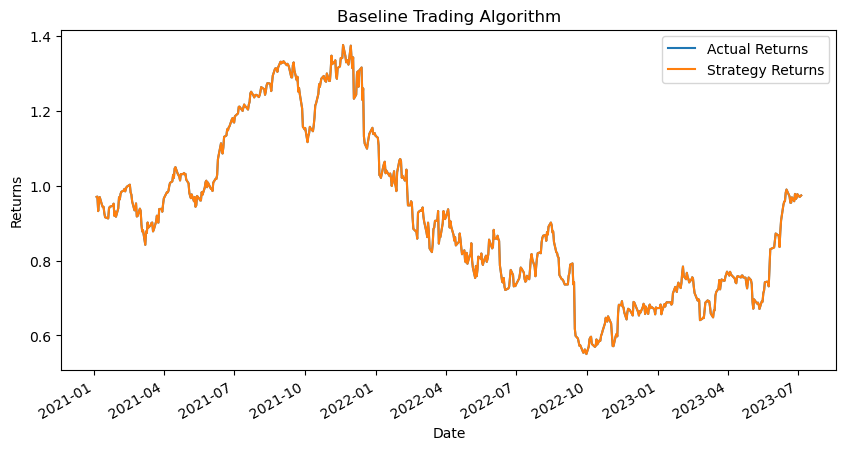

In [105]:
# Plot the actual returns versus the strategy returns
fig1 = (1+predictions_df[['Actual Returns','Strategy Returns']]).cumprod().plot(title = 'Baseline Trading Algorithm',
                                                                                          figsize = (10,5),
                                                                                                 ylabel = 'Returns'
                                                        
                                                                                         ).figure

# Files used to save charts commented out to not override current files
#fig1.savefig('images/baseline_3month_window_10_90days.png', bbox_inches ='tight')

## Adding trading costs to Backtesting Data

In [106]:
# Every time we change from long to short, or vice-versa, 2 trades occur
signals_df["Trades"] = np.abs(signals_df["Signal"].diff())

# Display sample data
signals_df.head()

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Trades
Date,,,,,,,,,,,,,,,,,,
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011602,0.000000,-0.022924,0.000442,-0.000234,1.0,NaN,NaN
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003208,0.007345,0.005028,-0.020622,-0.002977,0.014491,-0.015823,-0.001646,-0.007821,-0.004115,-0.000347,0.0,-0.014744,1.0
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018672,0.010337,-0.001909,-0.000101,1.0,0.000000,1.0
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000727,-0.008321,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453,0.0,-0.004418,1.0
2018-11-19,-0.080372,-0.050910,-0.087061,-0.012945,0.003024,-0.039087,-0.019376,0.007637,-0.049035,-0.057192,-0.018664,-0.038664,0.003293,-0.008193,-0.001508,0.0,-0.000000,0.0


In [107]:
# Calculate total daily trade costs
cost_per_trade = 0.005
daily_trade_costs = signals_df["Trades"] * cost_per_trade

# Display sample data
daily_trade_costs.head()

Date
2018-11-13      NaN
2018-11-14    0.005
2018-11-15    0.005
2018-11-16    0.005
2018-11-19    0.000
Name: Trades, dtype: float64

In [108]:
# Calculate strategy returns after costs
signals_df["Strategy Returns (After Costs)"] = signals_df["Strategy Returns"] - daily_trade_costs
signals_df.head()

,ADBE,AMZN,CRM,CSCO,CVX,GOOG,HD,JPM,MA,META,UNH,V,XOM,SMA_Fast,SMA_Slow,Signal,Strategy Returns,Trades,Strategy Returns (After Costs)
Date,,,,,,,,,,,,,,,,,,,
2018-11-13,0.008746,-0.003470,0.012720,-0.010960,-0.017378,-0.002484,-0.002396,0.005874,-0.004871,0.004309,-0.011602,0.000000,-0.022924,0.000442,-0.000234,1.0,NaN,NaN,NaN
2018-11-14,-0.014744,-0.019716,-0.021262,-0.017509,0.003208,0.007345,0.005028,-0.020622,-0.002977,0.014491,-0.015823,-0.001646,-0.007821,-0.004115,-0.000347,0.0,-0.014744,1.0,-0.019744
2018-11-15,0.020109,0.012777,0.024275,0.055042,0.020506,0.020169,-0.014119,0.025529,0.015842,-0.002565,-0.000075,0.018672,0.010337,-0.001909,-0.000101,1.0,0.000000,1.0,-0.005000
2018-11-16,-0.004418,-0.016073,0.000453,-0.008980,0.018042,-0.003024,-0.001917,-0.000727,-0.008321,-0.030031,0.023288,-0.011703,0.009848,-0.000051,-0.000453,0.0,-0.004418,1.0,-0.009418
2018-11-19,-0.080372,-0.050910,-0.087061,-0.012945,0.003024,-0.039087,-0.019376,0.007637,-0.049035,-0.057192,-0.018664,-0.038664,0.003293,-0.008193,-0.001508,0.0,-0.000000,0.0,-0.000000


<AxesSubplot:xlabel='Date'>

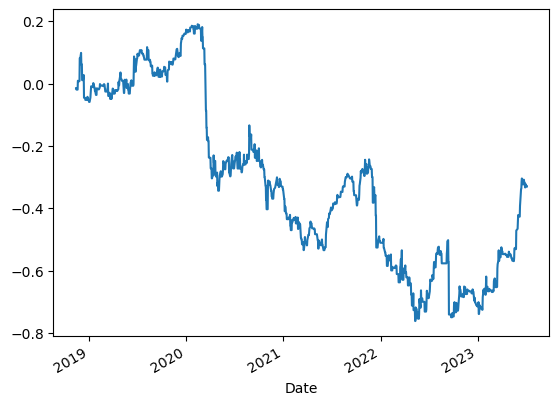

In [109]:
# Calculate the strategy's returns
strategy_returns = signals_df["Strategy Returns"].cumsum()

# Plot Strategy Returns to examine performance
strategy_returns.plot()

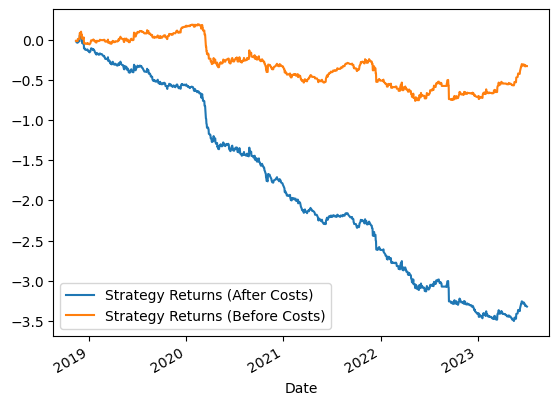

In [110]:
# Compute total strategy returns after costs
strategy_returns_after_costs = signals_df["Strategy Returns (After Costs)"].cumsum()

# Plot stategy returns before and after costs
strategy_returns_after_costs.plot(label="Strategy Returns (After Costs)")
strategy_returns.plot(label="Strategy Returns (Before Costs)")
plt.legend()